In [1]:
# file-handling
import os 

# user status updates
import time
from time import gmtime, strftime
from tqdm import tqdm
from IPython.display import display, Latex
from datetime import datetime

# the holy trinity of python data science
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# scipy
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad

# parallelization, memory management
from joblib import Parallel, delayed
from numba import jit, njit, prange
import copy

# itertools
import itertools

############ Macros ###############
np.random.seed(0)

# Physical constants
N = 12 # number of fermions
J = 100 # ~"energy scale"
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N_DIM = 2**N # Hilbert space dimension <-- Important: Hilbert space dimension is now 2^N instead of 2^(N/2). 

# Computer stuff
N_SAMPLES = 100 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel
EASY_DAGGER = True # whether to use the easy dagger function or the hard one
CHECK_ALGEBRA = False # Whether we want to check algebra
FLOAT_ERROR = 1e-15 # What we consider to be a floating point error; eigenvalues with absolute value less than FLOAT_ERROR will be considered zero

# Directories
N2_SUSY_DIR = os.path.join("Excel", "N2_SUSY_SYK")
RESULT_DIR = os.path.join(N2_SUSY_DIR, "Simulated Hamiltonians", f"N{N}_J{J}")
os.makedirs(RESULT_DIR, exist_ok=True)


# 1. Fermion operators

We've compartmentalized the whole thing (computing fermions, their daggers, pairwise and triple inner-products) to it's own Python function. 

In [2]:
from N2_SUSY_fermions import make_fermions
psi_dict = make_fermions(N, easy_dagger=EASY_DAGGER, check_algebra=CHECK_ALGEBRA, n_jobs=N_JOBS)

psi_all = psi_dict["psi_all"]
psi_dagger_all = psi_dict["psi_dagger_all"]
psi_psi_all = psi_dict["psi_psi_all"]
psi_dagger_psi_all = psi_dict["psi_dagger_psi_all"]
psi_psi_dagger_all = psi_dict["psi_psi_dagger_all"]
psi_dagger_psi_dagger_all = psi_dict["psi_dagger_psi_dagger_all"]
psi_psi_psi_all = psi_dict["psi_psi_psi_all"]

# 2. Random coefficients tensor, $C_{ijk}$

In [3]:
def levi_civita_tensor(dim):   
    arr=np.zeros(tuple([dim for i in range(dim)]), dtype=np.int32)
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x]=int(np.linalg.det(mat))
    return arr

def asym_perm(iterable):
    n_elem = len(iterable)
    if len(set(iterable)) < n_elem:
        return 0 # <-- If there are repeated elements, levi-civita value is identically zero 

    order_0 = tuple(list(range(n_elem)))
    all_orders = list(itertools.permutations(order_0))
    all_permutations = [tuple([iterable[i] for i in order]) for order in all_orders]

    lc_tensor = levi_civita_tensor(n_elem)
    out = {}
    for i in range(len(all_orders)):
        order_i = all_orders[i]
        multiplier = lc_tensor[order_i]

        permutation_i = all_permutations[i]
        out[permutation_i] = multiplier

    return out

def make_C(random_seed):
    np.random.seed(random_seed)

    sigma_C_squared = 2*J/(N**2)
    sigma_C_prime_squared = sigma_C_squared*(N**2)/((N-1)*(N-2))
    sigma_C = np.sqrt(sigma_C_squared)
    sigma_C_prime = np.sqrt(sigma_C_prime_squared)

    # Generate distribution for X', Y'
    N_UPPER = N*(N-1)*(N-2)//6
    sigma_XY_prime = sigma_C_prime/np.sqrt(2)
    X_prime = np.random.normal(0, sigma_XY_prime, size=(N_UPPER))
    Y_prime = np.random.normal(0, sigma_XY_prime, size=(N_UPPER))

    # Generate distribution for C'
    C_prime = X_prime + 1j*Y_prime

    # Initialize upper-upper-triangle array
    C_upper_upper = np.zeros(shape = [N for i in range(Q_COUPLING)], dtype=np.complex128)

    index = 0
    for i in range(N-2):
        for j in range(i+1, N-1):
            for k in range(j+1, N):
                C_upper_upper[i, j, k] = C_prime[index]
                index += 1

    # Antisymmetrize C_upper_upper to form full tensor C
    C = np.zeros(shape=[N for i in range(Q_COUPLING)], dtype=np.complex128)
    axes_og = range(len(C.shape))
    axes_asym_perms = asym_perm(axes_og)
    for axes, multiplier in axes_asym_perms.items():
        addendum = multiplier*np.transpose(C_upper_upper, axes)
        C += addendum

    return C

C = make_C(0)

## 3. Supercharge, $Q$

In [4]:
def make_Q(C):
    
    Q = sparse.csr_array(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
    for i_index in range(N-2):
        i_label = i_index+1

        for j_index in range(i_index+1, N-1):
            j_label = j_index+1

            for k_index in range(j_index+1, N):
                k_label = k_index+1

                C_ijk = C[i_index, j_index, k_index]
                psi_psi_psi_ijk = psi_psi_psi_all[(i_label, j_label, k_label)]
                Q += C_ijk*psi_psi_psi_ijk
        

    Q *= 1j
    return Q

Q = make_Q(C)
Q_bar = np.transpose(np.conjugate(Q))

## 4. Hamiltonian

In [5]:
def make_H(Q):
    Q_bar = np.transpose(np.conjugate(Q))
    H = Q@Q_bar + Q_bar@Q
    return H

H = make_H(Q)

## 5. Inspect eigenvectors

In [19]:
# get eigenvalues, eigenvectors
i_vals, i_vecs = np.linalg.eigh(H.toarray())

# sort in order of increasing eigenvalue
sorted_indeces = np.argsort(i_vals)
i_vals = np.array([i_vals[i] for i in sorted_indeces])
i_vecs = np.array([i_vecs[i,:] for i in sorted_indeces])

In [20]:
# Normalize eigenvectors 
def l2_norm(v):
    return v/np.sqrt(v@v)

i_vecs_normed = copy.deepcopy(i_vecs)
#i_vecs_normed = np.array([l2_norm(i_vecs[i,:]) for i in range(i_vecs.shape[0])])

iv0 = i_vecs_normed[0]
iv1 = i_vecs_normed[1]
iv2 = i_vecs_normed[9]

print(np.abs(iv0@iv0))
print(iv1@iv1)
print(np.abs(iv1@iv1))
print(iv2@iv2)

1.0
(1.0000000000000009+0j)
1.0000000000000009
(-0.05085186690532323+0.0065534270914502715j)


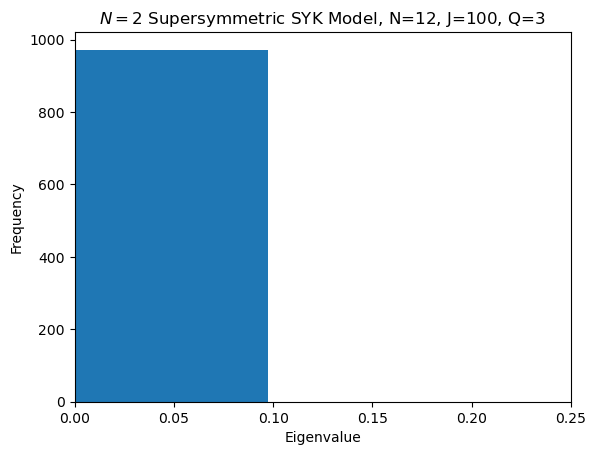

In [21]:
plt.figure()
plt.hist(i_vals, bins=4000)
plt.xlim(0,0.25)
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.title(r"$N=2$ Supersymmetric SYK Model, "+f"N={N}, J={J}, Q={Q_COUPLING}")
#plt.savefig(os.path.join(RESULT_DIR, "iv_hist_zoomed.png"))
plt.show()
plt.close()

In [9]:
FIRST_NONZERO = 0.1 # First seemingly non-zero eigenvalue from histogram
# zero-energy eigenvectors
i_vals_0_idx = np.where(i_vals<FIRST_NONZERO)[0]
i_vecs_0 = np.array([i_vecs_normed[i] for i in i_vals_0_idx])
i_vecs_0_r = i_vecs_0.real
i_vecs_0_i = i_vecs_0.imag
i_vecs_0_abs = np.abs(i_vecs_0)

# finite-energy eigenvectors
i_vals_n0_idx = np.where(i_vals>=FIRST_NONZERO)[0]
i_vecs_n0 = np.array([i_vecs_normed[i] for i in i_vals_n0_idx])
i_vecs_n0_r = i_vecs_n0.real
i_vecs_n0_i = i_vecs_n0.imag
i_vecs_n0_abs = np.abs(i_vecs_n0)

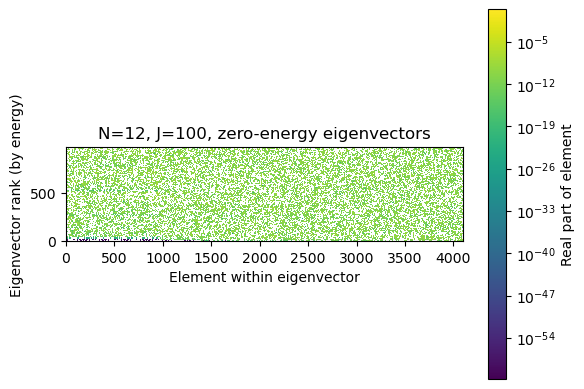

In [10]:
plt.figure()
plt.imshow(i_vecs_0_r, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, zero-energy eigenvectors")
plt.colorbar(label="Real part of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector_0 distribution real.png"))
plt.show()
plt.close()

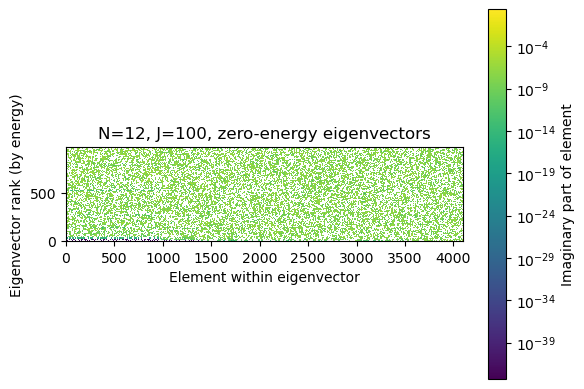

In [11]:
plt.figure()
plt.imshow(i_vecs_0_i, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, zero-energy eigenvectors")
plt.colorbar(label="Imaginary part of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector_0 distribution imaginary.png"))
plt.show()
plt.close()

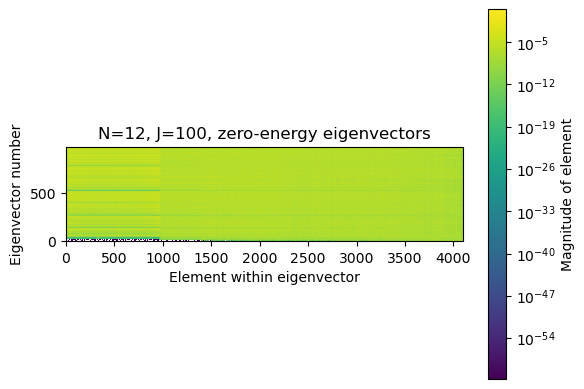

In [12]:
plt.figure()
plt.imshow(i_vecs_0_abs, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector number")
plt.title(f"N={N}, J={J}, zero-energy eigenvectors")
plt.colorbar(label="Magnitude of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector_0 distribution magnitude.png"))
plt.show()
plt.close()

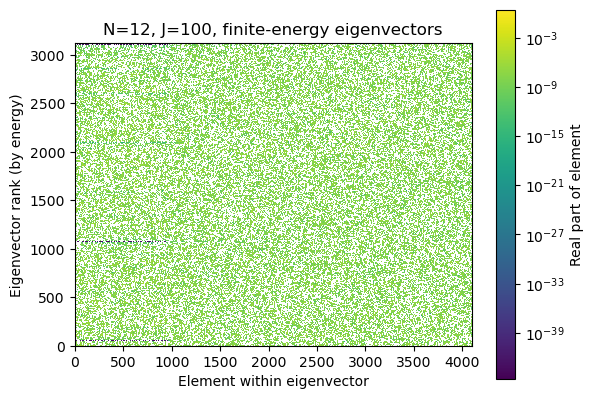

In [13]:
plt.figure()
plt.imshow(i_vecs_n0_r, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, finite-energy eigenvectors")
plt.colorbar(label="Real part of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector_n0 distribution real.png"))
plt.show()
plt.close()

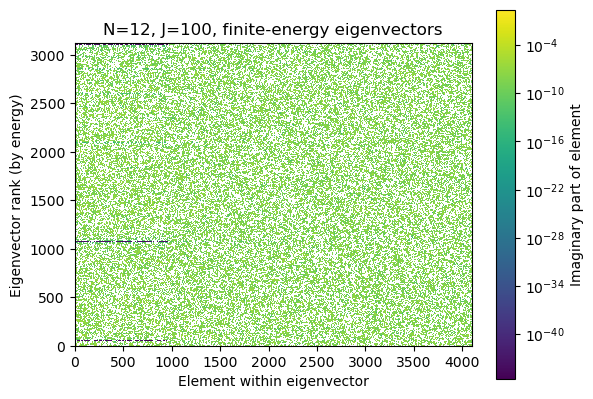

In [26]:
plt.figure()
plt.imshow(i_vecs_n0_i, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, finite-energy eigenvectors")
plt.colorbar(label="Imaginary part of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector_n0 distribution imaginary.png"))
plt.show()
plt.close()

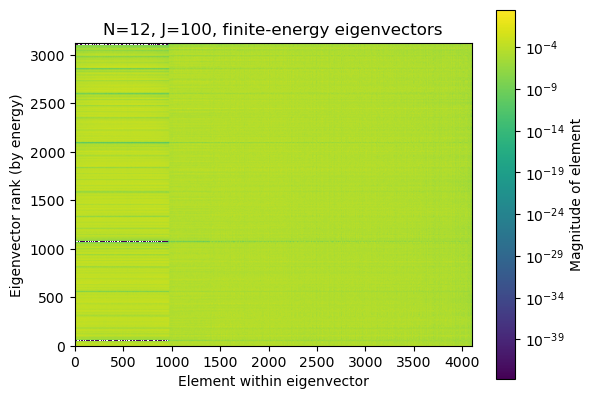

In [25]:
plt.figure()
plt.imshow(i_vecs_n0_abs, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, finite-energy eigenvectors")
plt.colorbar(label="Magnitude of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector_n0 distribution magnitude.png"))
plt.show()
plt.close()

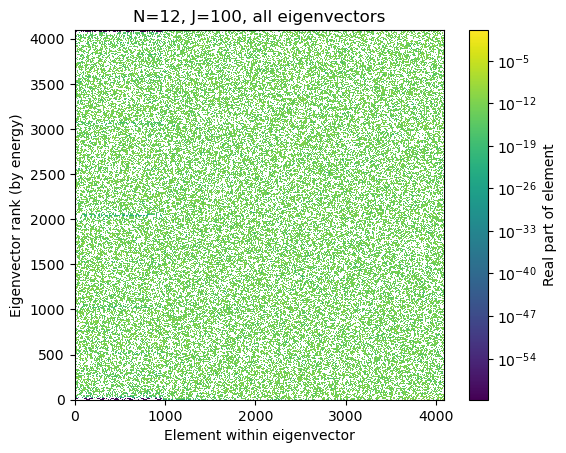

In [24]:
plt.figure()
plt.imshow(i_vecs.real, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, all eigenvectors")
plt.colorbar(label="Real part of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector distribution real.png"))
plt.show()
plt.close()

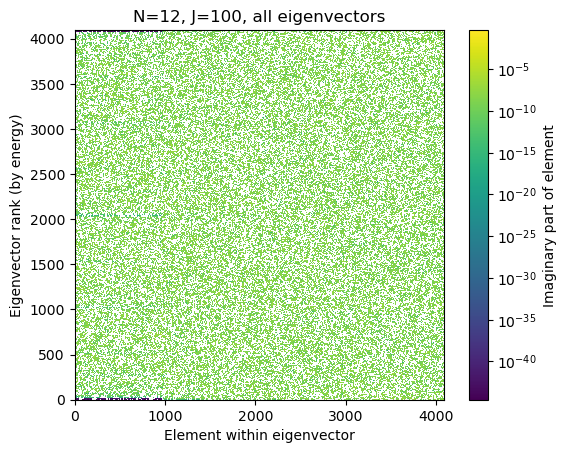

In [23]:
plt.figure()
plt.imshow(i_vecs.imag, norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, all eigenvectors")
plt.colorbar(label="Imaginary part of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector distribution imaginary.png"))
plt.show()
plt.close()

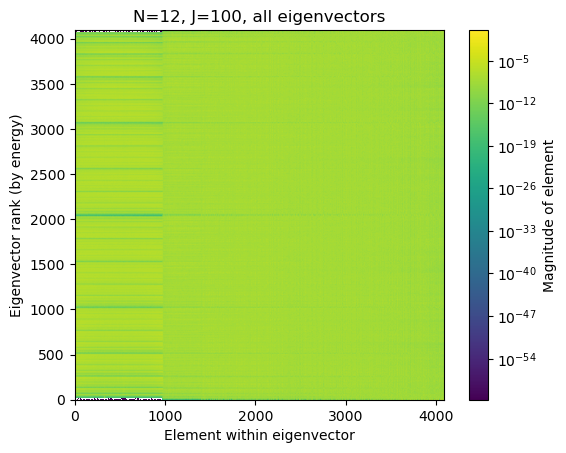

In [22]:
plt.figure()
plt.imshow(np.abs(i_vecs), norm="log", origin="lower")
plt.xlabel("Element within eigenvector")
plt.ylabel("Eigenvector rank (by energy)")
plt.title(f"N={N}, J={J}, all eigenvectors")
plt.colorbar(label="Magnitude of element")
plt.savefig(os.path.join(RESULT_DIR, "Eigenvector distribution magnitude.png"))
plt.show()
plt.close()

## 6. K-Means

In [ ]:
from sklearn.cluster import KMeans

i_vecs_r = i_vecs.real
kmeans_r = KMeans(n_clusters=2, random_state=1).fit(i_vecs_r)
labels_r = kmeans_r.labels_

i_vecs_i = i_vecs.imag
kmeans_i = KMeans(n_clusters=2, random_state=1).fit(i_vecs_i)
labels_i = kmeans_i.labels_

i_vecs_abs = np.abs(i_vecs)
kmeans_abs = KMeans(n_clusters=2, random_state=1).fit(i_vecs_abs)
labels_abs = kmeans_abs.labels_